In [1]:
# -*- coding: utf-8 -*-
"""
Author : Ang Ming Liang

This code is based on https://github.com/probml/pmtk3/blob/master/demos/sliceSamplingDemo2d.m
"""


import numpy as np
from scipy.stats import norm
from scipy.stats import binom
from matplotlib import cm
import matplotlib.pyplot as plt

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

from probml_utils.mcmc_utils import slice_sample

100%|██████████| 1000/1000 [00:03<00:00, 285.51it/s]
/home/patel_karm/probml-utils/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


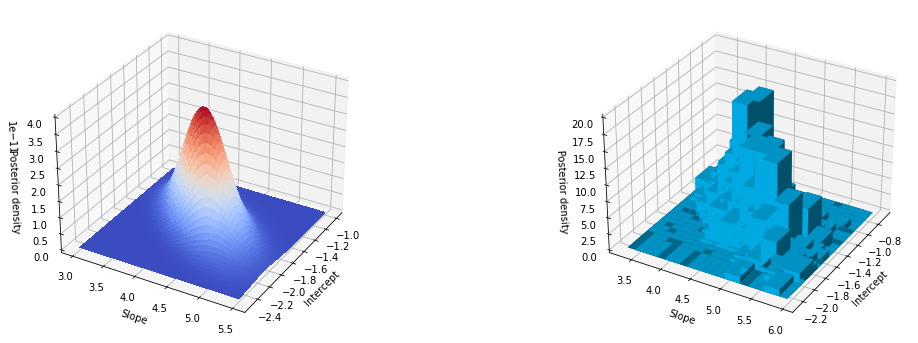

In [2]:
seed = 123
rng = np.random.default_rng(seed)

# A set of car weights
weight = np.array([2100, 2300, 2500, 2700, 2900, 3100, 3300, 3500, 3700, 3900, 4100, 4300])
weight = (weight - 2800) / 1000

# The number of cars tested at each weight
total = np.array([48, 42, 31, 34, 31, 21, 23, 23, 21, 16, 17, 21]).T

# The number of cars that have poor mpg performances at each weight
poor = np.array([1, 2, 0, 3, 8, 8, 14, 17, 19, 15, 17, 21])


def logitp(b1, b2, x):
    return np.exp(b1 + b2 * x) / (1 + np.exp(b1 + b2 * x))


def prior1(b1):
    # prior for intercept
    return norm.pdf(b1, 0, 20)


def prior2(b2):
    # prior for slope
    return norm.pdf(b2, 0, 20)


def post(b):
    return np.prod(binom.pmf(poor, total, logitp(b[0], b[1], weight))) * prior1(b[0]) * prior2(b[1])


b1 = np.linspace(-2.5, -1, 50)
b2 = np.linspace(3, 5.5, 50)
simpost = np.zeros((50, 50))
X, Y = np.meshgrid(b2, b1)

for i in range(1, len(b1)):
    for j in range(1, len(b2)):
        b = [b1[i], b2[j]]
        simpost[i, j] = post(b)

# Numerical evaluation of posteiror in 2d
initial = np.array([1.0, 1.0])
nsamples = 1000
x, y = slice_sample(initial, lambda x: np.log(post(x)), iters=nsamples, sigma=np.array([20, 2]), burnin=300, rng=rng)

fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(1, 2, 1, projection="3d")
ax.plot_surface(X, Y, simpost, cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.set_zlim(0, 4e-11)

ax.set_xlabel("Slope")
ax.set_ylabel("Intercept")
ax.set_zlabel("Posterior density")

# This hack is from https://stackoverflow.com/questions/48442713/move-spines-in-matplotlib-3d-plot/49601745#49601745
ax.zaxis._axinfo["juggled"] = (1, 2, 0)

hist, xedges, yedges = np.histogram2d(y, x, bins=20)

# Construct arrays for the anchor positions of the 400 bars.
# Note: np.meshgrid gives arrays in (ny, nx) so we use 'F' to flatten xpos,
# ypos in column-major order. For numpy >= 1.7, we could instead call meshgrid
# with indexing='ij'.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25)
xpos = xpos.flatten("F")
ypos = ypos.flatten("F")
zpos = np.zeros_like(xpos)

# Construct arrays with the dimensions for the 400 bars.
dx = 0.25 * np.ones_like(zpos)
dy = dx.copy()
dz = hist.flatten()

ax2 = fig.add_subplot(1, 2, 2, projection="3d")

ax2.set_xlabel("Slope")
ax2.set_ylabel("Intercept")
ax2.set_zlabel("Posterior density")

ax2.set_zlim(0, 20)

ax2.zaxis._axinfo["juggled"] = (1, 2, 0)
ax2.bar3d(xpos, ypos, zpos, dx, dy, dz, color="deepskyblue")
pml.savefig("sliceSamplingDemo2D.pdf")
plt.show()